# Hierarchical Binominal Model: Rat Tumor Example

In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# import pymc3.distributions.transforms as tr
# import theano.tensor as tt
from scipy.special import gammaln

plt.style.use('seaborn-darkgrid')
# print('Running on PyMC3 v{}'.format(pm.__version__))

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


This short tutorial demonstrates how to use pymc3 to do inference for the rat tumour example found in chapter 5 of *Bayesian Data Analysis 3rd Edition*.  Readers should already be familliar with the pymc3 api.

Suppose we are interested in the probability that a lab rat develops endometrial stromal polyps.  We have data from 71 previously performed trials and would like to use this data to perform inference.

The authors of BDA3 choose to model this problem heirarchically.  Let $y_i$ be the number of lab rats which develop endometrial stromal polyps out of a possible $n_i$.  We model the number rodents which develop endometrial stromal polyps as binomial

$$ y_i \sim \operatorname{Bin}(\theta_i;n_i)$$

allowing the probability of developing an endometrial stromal polyp (i.e. $\theta_i$) to be drawn from some population distribution.  For analytical tractability, we assume that $\theta_i$ has Beta distribution

$$ \theta_i \sim \operatorname{Beta}(\alpha, \beta)$$

We are free to specify a prior distribution for $\alpha, \beta$.  We choose a weakly informative prior distribution to reflect our ignorance about the true values of $\alpha, \beta$.  The authors of BDA3 choose the joint hyperprior for $\alpha, \beta$ to be

$$ p(\alpha, \beta) \propto (\alpha + \beta) ^{-5/2}$$

For more information, please see *Bayesian Data Analysis 3rd Edition* pg. 110.

## A Directly Computed Solution

Our joint posterior distribution is

$$p(\alpha,\beta,\theta \lvert y) 
\propto 
p(\alpha, \beta) 
p(\theta \lvert \alpha,\beta)
p(y \lvert \theta)$$

which can be rewritten in such a way so as to obtain the marginal posterior distribution for $\alpha$ and $\beta$, namely

$$ p(\alpha, \beta, \lvert y) = 
p(\alpha, \beta) 
\prod_{i = 1}^{N} \dfrac{\Gamma(\alpha+\beta)}{\Gamma(\alpha)\Gamma(\beta)}
\dfrac{\Gamma(\alpha+y_i)\Gamma(\beta+n_i - y_i)}{\Gamma(\alpha+\beta+n_i)}$$


See BDA3 pg. 110 for a more information on the deriving the marginal posterior distribution. With a little determination, we can plot the marginal posterior and estimate the means of $\alpha$ and $\beta$ without having to resort to MCMC.  We will see, however, that this requires considerable effort.

The authors of BDA3 choose to plot the surfce under the paramterization $(\log(\alpha/\beta), \log(\alpha+\beta))$.  We do so as well.  Through the remainder of the example let $x = \log(\alpha/\beta)$ and $z = \log(\alpha+\beta)$.



In [2]:
# rat data (BDA3, p. 102)
y = np.array([
    0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,
    1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  5,  2,
    5,  3,  2,  7,  7,  3,  3,  2,  9, 10,  4,  4,  4,  4,  4,  4,  4,
    10,  4,  4,  4,  5, 11, 12,  5,  5,  6,  5,  6,  6,  6,  6, 16, 15,
    15,  9,  4
])
n = np.array([
    20, 20, 20, 20, 20, 20, 20, 19, 19, 19, 19, 18, 18, 17, 20, 20, 20,
    20, 19, 19, 18, 18, 25, 24, 23, 20, 20, 20, 20, 20, 20, 10, 49, 19,
    46, 27, 17, 49, 47, 20, 20, 13, 48, 50, 20, 20, 20, 20, 20, 20, 20,
    48, 19, 19, 19, 22, 46, 49, 20, 20, 23, 19, 22, 20, 20, 20, 52, 46,
    47, 24, 14
])

N = len(n)

In [3]:
data = pd.DataFrame({"nm_tumors" : y, "nm_rats": n})
data.head()

,nm_tumors,nm_rats
0,0,20
1,0,20
2,0,20
3,0,20
4,0,20


In [5]:
theta_mean = data.iloc[:-1, :].eval("nm_tumors / nm_rats").mean()
theta_var = data.iloc[:-1, :].eval("nm_tumors / nm_rats").var()

a_plus_b = (theta_mean * (1 - theta_mean)) / theta_var - 1

alpha = theta_mean * a_plus_b
beta = (1 - theta_mean) * a_plus_b
print(f"Only using moments in beta distribution, alpha: {alpha} and beta : {beta} means.")

Only using moments in beta distribution, alpha: 1.356149391031933 and beta : 8.615057891320788 means.


In [6]:
# Create space for the parameterization in which we wish to plot
X, Z = np.meshgrid(np.arange(-2.3, -1.3, 0.01), np.arange(1, 5, 0.01))
param_space = np.c_[X.ravel(), Z.ravel()]
df = pd.DataFrame(param_space, columns=['X', 'Z'])

First we have a dataframe with $x$ and $z$ values. If $x = \log(\alpha/\beta)$ and $z = \log(\alpha+\beta)$, so $\beta = e^z \, / \, (1 + e^x)$ and $\alpha = e^{x + z} \, / \, (1 + e^x)$

To create the plot, we first compute the logarithm of the density function $(5.8)$ with prior density $(5.9)$, multiplying by the Jacobian to obtain the density $p(\log(\alpha / \beta), \log (\alpha + \beta) \, \vert \, y)$

$$ \log p(\alpha, \beta, \lvert y) = 
\log \left[
    (\alpha +  \beta)^{-5/2}
    \prod_{i = 1}^{N} \dfrac{\Gamma(\alpha+\beta)}{\Gamma(\alpha)\Gamma(\beta)}
    \dfrac{\Gamma(\alpha+y_i)\Gamma(\beta+n_i - y_i)}{\Gamma(\alpha+\beta+n_i)}
  \right] 
    $$

In [8]:
def trans_to_beta(x, z):

    return np.exp(z) / (np.exp(x) + 1)


def trans_to_alpha(x, z):

    return np.exp(x) * trans_to_beta(x, z)


# Compute on log scale because products turn to sums
def log_likelihood(alpha, beta, y, n):
    
    LL = 0
    # Summing over data
    for Y, N in zip(y, n):
        LL += (
            gammaln(alpha + beta)
            - gammaln(alpha)
            - gammaln(beta)
            + gammaln(alpha + Y)
            + gammaln(beta + N - Y)
            - gammaln(alpha + beta + N)
        )

    return LL


def log_prior(alpha, beta):

    return - 2.5 * np.log(alpha + beta)

In [9]:
df = df.assign(
    alpha=lambda x: trans_to_alpha(x["X"], x["Z"]),  # Transform the space back to alpha beta to compute the log-posterior
    beta=lambda x: trans_to_beta(x["X"], x["Z"]), 
    log_posterior=lambda x: log_prior(x["alpha"], x["beta"]) + log_likelihood(x["alpha"], x["beta"], y, n),
    log_jacobian=lambda x: np.log(x["alpha"]) + np.log(x["beta"]),
    transformed=lambda x: x["log_posterior"] + x["log_jacobian"],
    exp_trans=lambda x: np.exp(x["transformed"] - x["transformed"].max()),
    normed_exp_trans=lambda x: x["exp_trans"] / x["exp_trans"].sum()  # This will ensure the density is normalized
)
df.head()

,X,Z,alpha,beta,log_posterior,log_jacobian,transformed,exp_trans,normed_exp_trans
0,-2.30,1.0,0.247698,2.470584,-764.886923,-0.491091,-765.378014,1.979035e-14,8.775273e-18
1,-2.29,1.0,0.249958,2.468323,-764.571996,-0.482922,-765.054918,2.733834e-14,1.212214e-17
2,-2.28,1.0,0.252237,2.466044,-764.259599,-0.474769,-764.734368,3.766909e-14,1.670292e-17
3,-2.27,1.0,0.254535,2.463747,-763.949753,-0.466633,-764.416387,5.177053e-14,2.295566e-17
4,-2.26,1.0,0.256851,2.461430,-763.642483,-0.458515,-764.100998,7.096663e-14,3.146744e-17


In [10]:
surface = df.set_index(['X', 'Z']).exp_trans.unstack().values.T

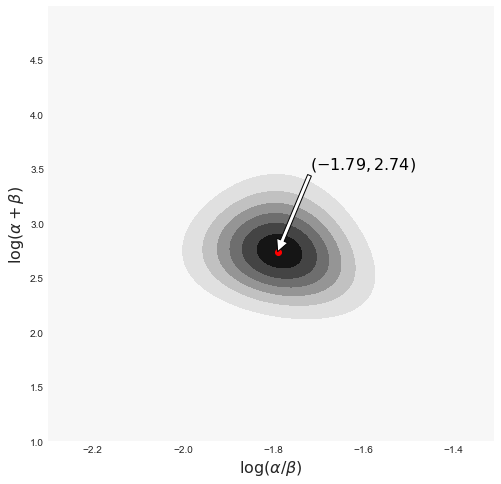

In [11]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.contourf(X, Z, surface)
ax.set_xlabel(r'$\log(\alpha/\beta)$', fontsize=16)
ax.set_ylabel(r'$\log(\alpha+\beta)$', fontsize=16)

ix_z, ix_x = np.unravel_index(np.argmax(surface, axis=None), surface.shape)
ax.scatter([X[0, ix_x]], [Z[ix_z, 0]], color='red')

text = r"$({a},{b})$".format(a=np.round(
    X[0, ix_x], 2), b=np.round(Z[ix_z, 0], 2))

ax.annotate(text,
            xy=(X[0, ix_x], Z[ix_z, 0]),
            xytext=(-1.6, 3.5),
            ha='center',
            fontsize=16,
            color='black',
            arrowprops={'facecolor':'white'}
            );

In [12]:
x_hat=np.round(X[0, ix_x], 2)
z_hat=np.round(Z[ix_z, 0], 2)

In [13]:
alpha_hat = trans_to_alpha(x_hat, z_hat)
beta_hat = trans_to_beta(x_hat, z_hat)

In [14]:
print(alpha_hat)
print(beta_hat)

2.2157651362287765
13.271219960111162


The plot shows that the posterior is roughly symetric about the mode (-1.79, 2.74).  This corresponds to $\alpha = 2.21$ and $\beta = 13.27$. We can compute the marginal means as the authors of BDA3 do, using

$$ \operatorname{E}(\alpha \lvert y) \text{   is estimated by   }
\sum_{x,z} \alpha p(x,z\lvert y) $$

$$ \operatorname{E}(\beta \lvert y) \text{   is estimated by   }
\sum_{x,z} \beta p(x,z\lvert y) $$

In [15]:
#Estimated mean of alpha
(df.alpha*df.normed_exp_trans).sum().round(3)

2.403

In [16]:
#Estimated mean of beta
(df.beta*df.normed_exp_trans).sum().round(3)

14.319